# Modelos lineales



## Librerías

In [1]:
import seaborn as sns
import bambi as bmb
import arviz as az
print('Librerías importadas')

Librerías importadas


## Datos
En esta libreta utilizaremos un modelo lineal múltiple. Utilizaremos un dataset incluido en `bambi`. Este ejemplo está basado en esta [libreta](https://bambinos.github.io/bambi/notebooks/ESCS_multiple_regression.html).

Los datos que utilizaremos son de un estudio poblacional en el que se midieron docenas de índices de personalidad en adultos. Este subset contiene cinco predictores numéricos que son sumas de puntuaciones de cinco dimensiones de la personalidad. Las dimenciones son:

- O = Apertura a la experiencia
- C = Responsabilidad/conciencia
- E = Extraversión
- A = Amabilidad/Afabilidad
- N = Neuroticismo

Puedes leer más de este dataset aquí:

> Goldberg, L. R. (2008). The Eugene–Springfield community sample: Information available from the research participants (ORI Technical Report No. 48). http://ipip.ori.org/ORI_TechnicalReport_ESCS_Mar08.pdf



In [29]:
data = bmb.load_data("ESCS")
data.head()

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
0,1.857143,117,102,122,115,89,3.43750,3.46875,3.68750,3.28125,3.18750,3.96875
1,3.071429,69,92,142,140,132,4.21875,2.59375,3.56250,3.34375,3.84375,3.87500
2,1.571429,69,101,117,148,173,3.87500,3.46875,2.81250,2.75000,3.84375,3.25000
3,2.214286,87,99,130,135,134,3.68750,3.09375,2.93750,3.09375,3.62500,3.96875
4,1.071429,50,116,100,117,130,4.12500,2.59375,3.40625,3.71875,3.84375,3.56250


Nos enfocaremos solo en las primeras 6 variables, las cinco dimensiones y `drugs`, nuestra variable de salida, un índice autoreportado del consumo de estupefacientes.

## Reconocimiento y exploración de los datos

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   drugs   604 non-null    float64
 1   n       604 non-null    int64  
 2   e       604 non-null    int64  
 3   o       604 non-null    int64  
 4   a       604 non-null    int64  
 5   c       604 non-null    int64  
 6   hones   604 non-null    float64
 7   emoti   604 non-null    float64
 8   extra   604 non-null    float64
 9   agree   604 non-null    float64
 10  consc   604 non-null    float64
 11  openn   604 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 56.8 KB


In [31]:
data.columns

Index(['drugs', 'n', 'e', 'o', 'a', 'c', 'hones', 'emoti', 'extra', 'agree',
       'consc', 'openn'],
      dtype='object')

### Visualizaciones

Seaborn tiene una función `sns.pairplot` que genera una matriz de dispersión con todos los pares, pero dado que estamos utilizando `bambi`, mostraré cómo utilizar `arviz`. 

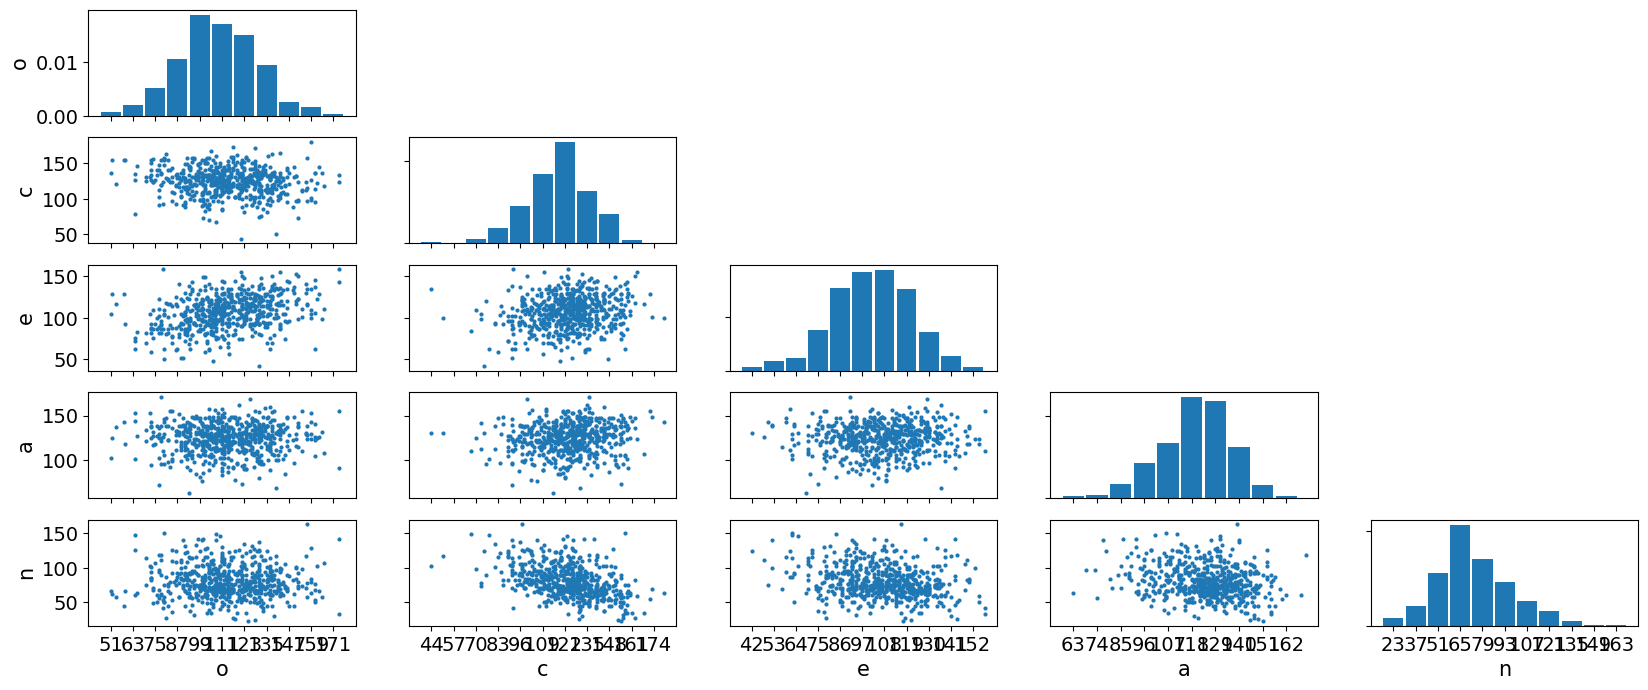

In [82]:
az.plot_pair(
    data[["o", "c", "e", "a", "n"]].to_dict("list"), # list hace que los valores de cada columna se junten en una lista
    marginals=True,
    figsize=(20, 8),
    
);


## Modelo
Como nuestra variable de salida es `drugs` las dimensiones de la personalidad serán nuestros predictores.
No asumiremos interacción entre ellas ni otros factores externos.

En este ejemplo, dejaremos que `bambi` seleccione los priors, que serán por defecto, levemente informativos, lo que permite que la inferencia sea dominada por los datos, no por la probabilidad previa.

### Preparación de los datos


In [46]:
model = bmb.Model(
    'drugs ~ o + c + e + a + n', # la fórmula
    data=data, # los datos
    dropna=True, # especificamos que queremos quitar los NaN
    family='gaussian', # la familia de la variable dependiente
)
model # lo ponemos para ver la especificación.

       Formula: drugs ~ o + c + e + a + n
        Family: gaussian
          Link: mu = identity
  Observations: 604
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.2101, sigma: 21.1938)
            o ~ Normal(mu: 0.0, sigma: 0.0768)
            c ~ Normal(mu: 0.0, sigma: 0.0868)
            e ~ Normal(mu: 0.0, sigma: 0.0816)
            a ~ Normal(mu: 0.0, sigma: 0.0973)
            n ~ Normal(mu: 0.0, sigma: 0.0699)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.6482)

In [47]:
result = model.fit(chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, o, c, e, a, n]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


### Diagnóstico de convergencia
Cuando corras el código en tu libreta deberías ver que no tuvimos divergencias, pero analicemos la traza.

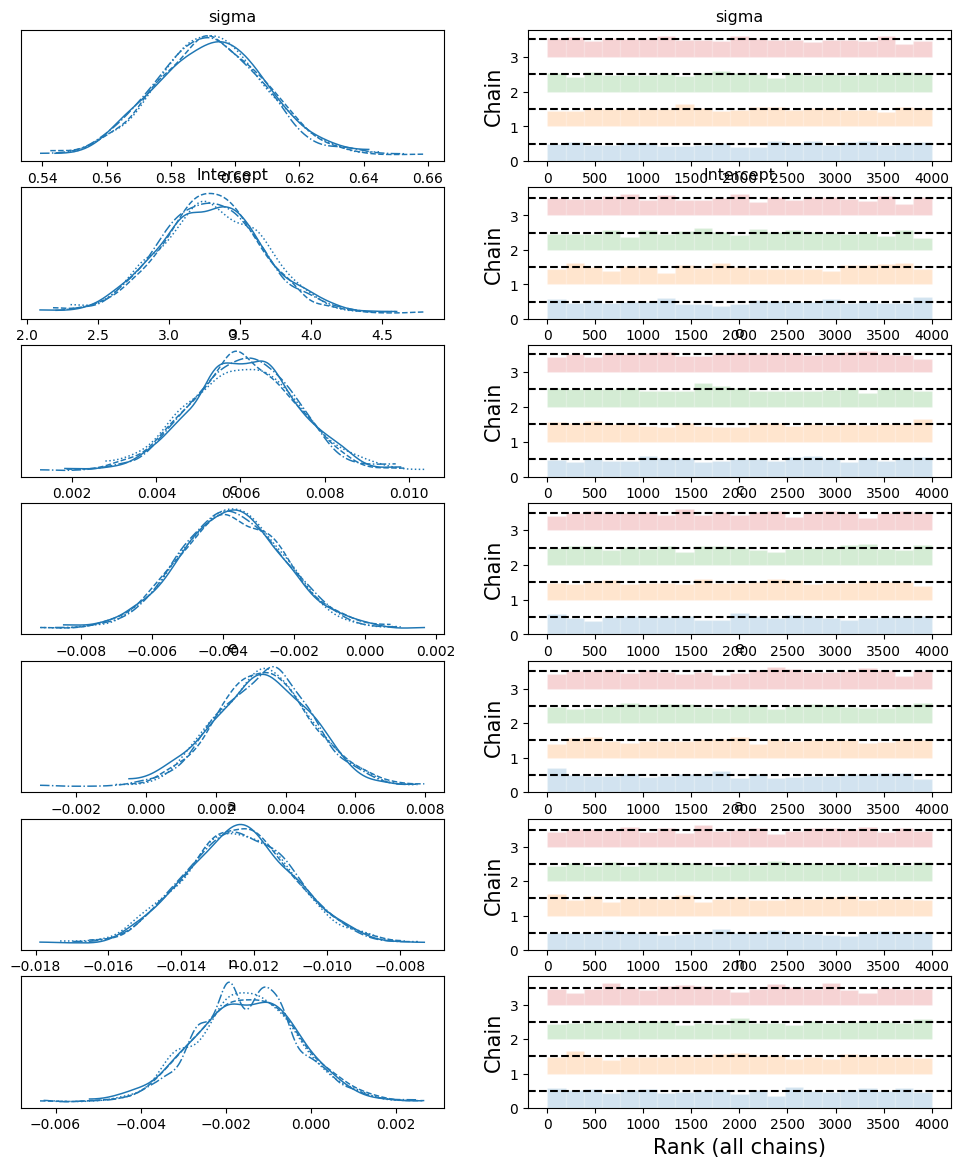

In [51]:
az.plot_trace(result, kind='rank_bars');

Podemos ver que las cadenas convirgieron exitosamente, lo que indica que las cadenas Markov muestrearon uniformemente todo el espacio de probabilidad posterior.

### Análisis de coeficientes

In [48]:
az.summary(result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.593,0.017,0.561,0.623,0.000,0.000,4537.0,3350.0,1.0
Intercept,3.292,0.361,2.646,3.990,0.005,0.006,4452.0,3126.0,1.0
o,0.006,0.001,0.004,0.008,0.000,0.000,3985.0,2885.0,1.0
c,-0.004,0.001,-0.007,-0.001,0.000,0.000,4235.0,3138.0,1.0
e,0.003,0.001,0.001,0.006,0.000,0.000,4147.0,3016.0,1.0
a,-0.012,0.001,-0.015,-0.010,0.000,0.000,4848.0,2964.0,1.0
n,-0.001,0.001,-0.004,0.001,0.000,0.000,4738.0,3467.0,1.0


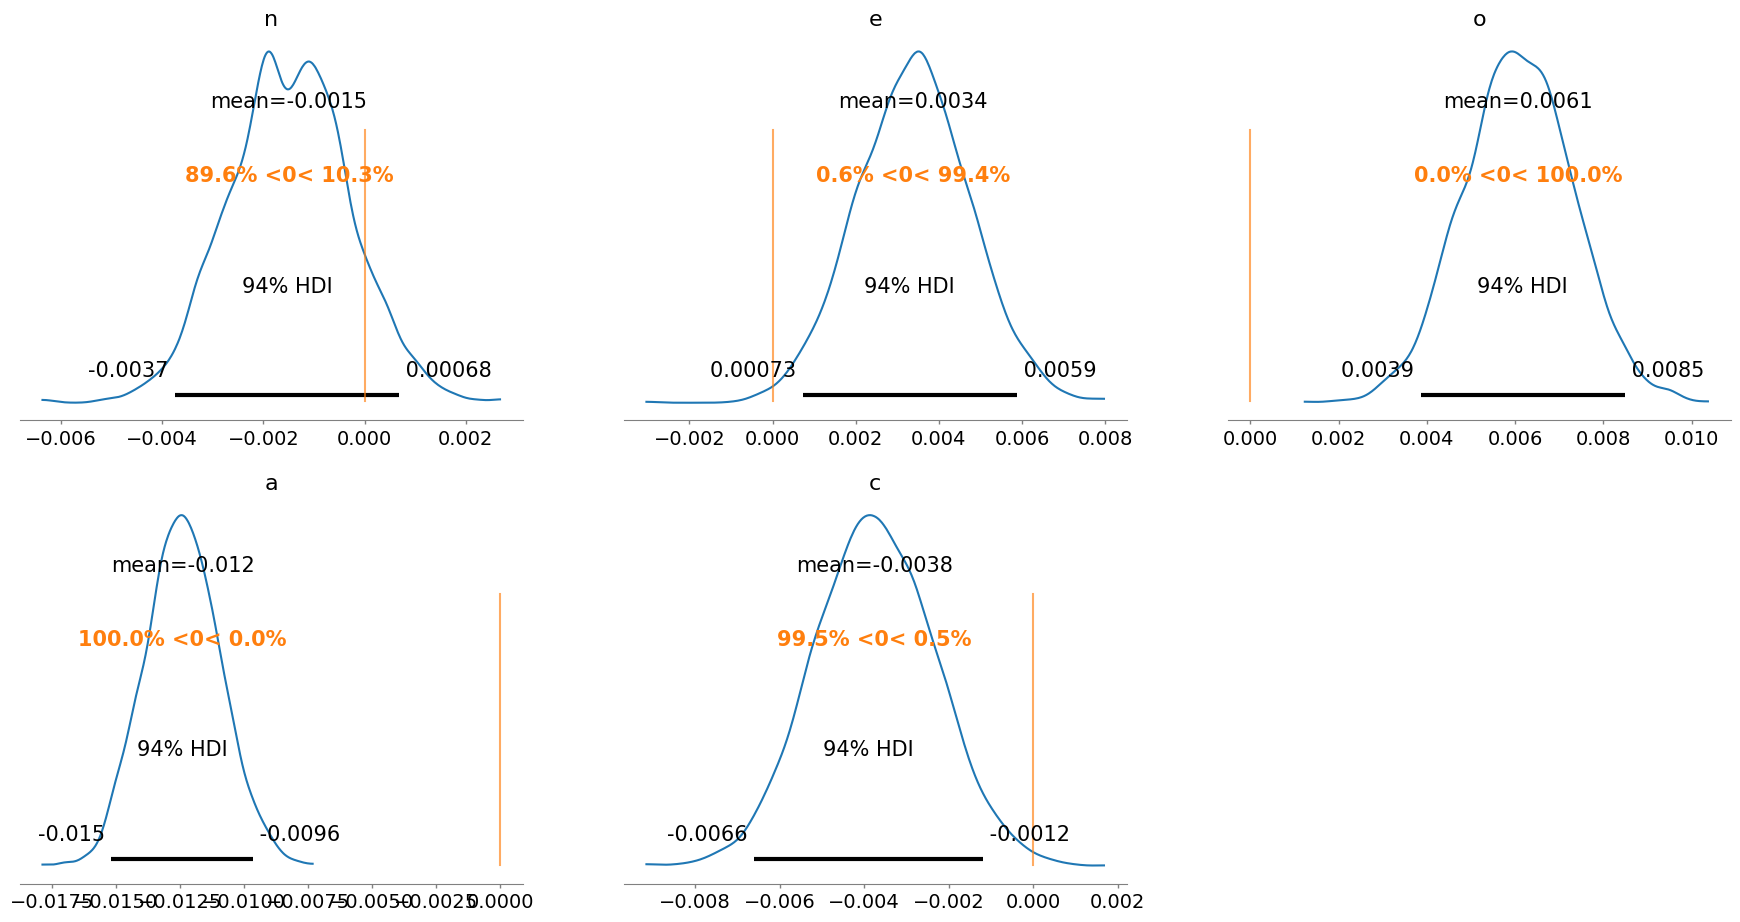

In [66]:
az.plot_posterior(result, ref_val=0, var_names=['n', 'e', 'o', 'a', 'c']);

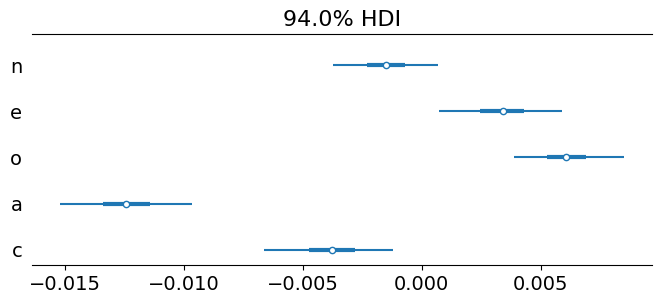

In [64]:
az.plot_forest(
    result,
    var_names=['n', 'e', 'o', 'a', 'c'], 
    combined=True, # combina todas las cadenas
    figsize=(8, 3) # mejora el aspecto
);

Podemos ver que la dimensión de afabilidad (agreeableness) se correlaciona de forma inversa al consumo de drogas, es un fuerte predictor, de forma similar, la apertura a experiencias (openess) es un predictor positivo.


## Conclusión

Modelar con un marco de trabajo bayesiano es sencillo e intuitivo en `python` al utilizar librerías de alto nivel como `bambi` y `arviz`.

## Ejercicios
1. Realiza un análisis similar con tus propios datos.
2. Explora qué otros datasets se incluyen en `bambi`.

